# Benchmarks

In [1]:
import logging
import os

logging.basicConfig(level=os.environ.get("LOGLEVEL", "INFO"))

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from l2_orderbook_tops import l2_orderbook_tops, loader

In [4]:
pd.set_option('display.max_colwidth', None)

In [5]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_columns', None)

In [6]:
INPUT_DIR='/storage/m2/market_data/raw/crypto/binance/BTCUSDT/orderbook'
SAMPLE_DATE='2020-11-01'

## Naive Python/Numpy implementation

In [7]:
def apply_side(p_prices, p_qtys, price, qty):
    pos = np.searchsorted(p_prices, price)

    if price not in p_prices:
        p_prices = np.insert(p_prices, pos, price)
        p_qtys = np.insert(p_qtys, pos, qty)
    else:
        if qty == 0.0:
            p_prices = np.delete(p_prices, pos)
            p_qtys = np.delete(p_qtys, pos)
        else:
            p_qtys[pos] = qty

    return p_prices, p_qtys
    
def l2_walk_naive(data, top_n):

    bid_prices, bid_qtys = np.array([]), np.array([])
    ask_prices, ask_qtys = np.array([]), np.array([])
    out = []

    for ts, side, price, qty in data:
        
        if side == 1:
            bid_prices, bid_qtys = apply_side(bid_prices, bid_qtys, price, qty)
        else:
            ask_prices, ask_qtys = apply_side(ask_prices, ask_qtys, price, qty)
            
        top_bids = np.stack((bid_prices[-top_n:], bid_qtys[-top_n:])).flatten(order='F')
        top_asks = np.stack((bid_prices[:top_n], bid_qtys[:top_n])).flatten(order='F')
        
        _out = np.concatenate((top_bids, top_asks))
        out.append(_out)

    return out

# Benchmarks

In [8]:
snap, delta = loader.get_binance_orderbook_snap_delta(INPUT_DIR, SAMPLE_DATE)
df = pd.concat([snap, delta])

In [9]:
data =  df[['timestamp', 'side', 'price', 'qty']] \
    .head(100000)

### Time naive implementation

In [10]:
%%timeit -o 

ret = l2_walk_naive(data.values, 8)

5.23 s ± 41.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 5.23 s ± 41.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [11]:
timings = _
naive_t = np.mean(timings.timings)
naive_t

5.231963757841315

### Time plb C++ implementation

In [12]:
data = loader.set_types(data)

In [13]:
%%timeit -o 

ret = l2_orderbook_tops.get_tops(data, watch_dollar_dist_depth=0)

INFO:root:Calculating top(8, watch_depth=0)
INFO:root:Calculating top(8, watch_depth=0)
INFO:root:Calculating top(8, watch_depth=0)
INFO:root:Calculating top(8, watch_depth=0)
INFO:root:Calculating top(8, watch_depth=0)
INFO:root:Calculating top(8, watch_depth=0)
INFO:root:Calculating top(8, watch_depth=0)
INFO:root:Calculating top(8, watch_depth=0)
INFO:root:Calculating top(8, watch_depth=0)
INFO:root:Calculating top(8, watch_depth=0)
INFO:root:Calculating top(8, watch_depth=0)
INFO:root:Calculating top(8, watch_depth=0)
INFO:root:Calculating top(8, watch_depth=0)
INFO:root:Calculating top(8, watch_depth=0)
INFO:root:Calculating top(8, watch_depth=0)
INFO:root:Calculating top(8, watch_depth=0)
INFO:root:Calculating top(8, watch_depth=0)
INFO:root:Calculating top(8, watch_depth=0)
INFO:root:Calculating top(8, watch_depth=0)
INFO:root:Calculating top(8, watch_depth=0)
INFO:root:Calculating top(8, watch_depth=0)
INFO:root:Calculating top(8, watch_depth=0)
INFO:root:Calculating top(8, wat

41.1 ms ± 4.62 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 41.1 ms ± 4.62 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [14]:
timings = _
plb_t = np.mean(timings.timings)
plb_t

0.04112289032865581

### Time plb C++ implementation + track qtys within $50 of mid

In [15]:
%%timeit -o 

ret = l2_orderbook_tops.get_tops(data, watch_dollar_dist_depth=5000)

INFO:root:Calculating top(8, watch_depth=5000)
INFO:root:Calculating top(8, watch_depth=5000)
INFO:root:Calculating top(8, watch_depth=5000)
INFO:root:Calculating top(8, watch_depth=5000)
INFO:root:Calculating top(8, watch_depth=5000)
INFO:root:Calculating top(8, watch_depth=5000)
INFO:root:Calculating top(8, watch_depth=5000)
INFO:root:Calculating top(8, watch_depth=5000)


323 ms ± 8.59 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 323 ms ± 8.59 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [16]:
timings = _
plb_t_d50 = np.mean(timings.timings)
plb_t_d50

0.3228008638501966

### Time plb C++ implementation + track qtys within $100 of mid

In [17]:
%%timeit -o 

ret = l2_orderbook_tops.get_tops(data, watch_dollar_dist_depth=10000)

INFO:root:Calculating top(8, watch_depth=10000)
INFO:root:Calculating top(8, watch_depth=10000)
INFO:root:Calculating top(8, watch_depth=10000)
INFO:root:Calculating top(8, watch_depth=10000)
INFO:root:Calculating top(8, watch_depth=10000)
INFO:root:Calculating top(8, watch_depth=10000)
INFO:root:Calculating top(8, watch_depth=10000)
INFO:root:Calculating top(8, watch_depth=10000)


618 ms ± 19.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 618 ms ± 19.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [18]:
timings = _
plb_t_d100 = np.mean(timings.timings)
plb_t_d100

0.6180378489661962

# Plots

In [19]:
results = pd.DataFrame.from_dict({
    'Implementation': ['naive', 'plb', 'plb50', 'plb100'],
    'Avg. Time (Secs)': [naive_t, plb_t, plb_t_d50, plb_t_d100]
})

results['Speed up'] = results.iloc[0]['Avg. Time (Secs)'] / results['Avg. Time (Secs)']
results

,Implementation,Avg. Time (Secs),Speed up
0,naive,5.231964,1.000000
1,plb,0.041123,127.227530
2,plb50,0.322801,16.208023
3,plb100,0.618038,8.465442


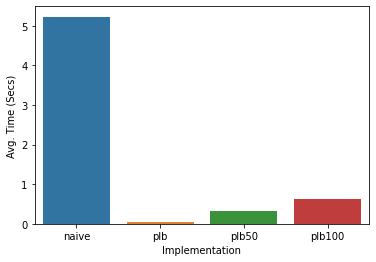

In [21]:
ax = sns.barplot(x=results['Implementation'], y=results['Avg. Time (Secs)'])

fig = ax.get_figure()
fig.savefig('benchmarks.png')